In [13]:
import numpy as np
from pysrc.optimization import gams, gurobi
from pysrc.sampling import baseline
from pysrc.services.data_service import load_site_data
from pysrc.analysis import value_decomposition

In [14]:
opt = "gurobi"
pee = 7.1
pa = 41.11
b = 25
sitenum = 78
timehzn = 250

In [15]:
# Load site data
(
    zbar_2017,
    z_2017,
    forest_area_2017,
    _,
    _,
    _,
    _,
) = load_site_data(sitenum)

# Set productivity parameters using baseline mean
baseline_fit = baseline.sample(
    model_name="full_model",
    num_sites=sitenum,
    iter_sampling=10**4,
    chains=5,
    seed=1,
)

theta = baseline_fit.stan_variable("theta").mean(axis=0)
gamma = baseline_fit.stan_variable("gamma").mean(axis=0)

# Computing carbon absorbed in start period
x0_vals = gamma * forest_area_2017

# Choose optimizer
if opt == "gurobi":
    solve_planner_problem = gurobi.solve_planner_problem

elif opt == "gams":
    solve_planner_problem = gams.solve_planner_problem

else:
    raise ValueError("Optimizer must be one of ['gurobi', 'gams']")

results = solve_planner_problem(
    T=timehzn,
    theta=theta,
    gamma=gamma,
    x0=x0_vals,
    zbar=zbar_2017,
    z0=z_2017,
    pe=pee + b,
    pa=pa,
)

Data successfully loaded from /Users/ph2696/Projects/project-amazon/data/hmc


16:06:08 - cmdstanpy - INFO - compiling stan file /Users/ph2696/Projects/project-amazon/stan_models/full_model/baseline.stan to exe file /Users/ph2696/Projects/project-amazon/stan_models/full_model/baseline


Data successfully loaded from /Users/ph2696/Projects/project-amazon/data/hmc


16:06:14 - cmdstanpy - INFO - compiled model executable: /Users/ph2696/Projects/project-amazon/stan_models/full_model/baseline
16:06:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:  900 / 10000 [  9%]  (Sampling)





chain 1 |██▏       | 00:00 Iteration: 2200 / 10000 [ 22%]  (Sampling)







chain 1 |███▏      | 00:00 Iteration: 3400 / 10000 [ 34%]  (Sampling)





chain 1 |████▍     | 00:00 Iteration: 4700 / 10000 [ 47%]  (Sampling)



chain 1 |█████▌    | 00:00 Iteration: 6000 / 10000 [ 60%]  (Sampling)





chain 1 |██████▊   | 00:00 Iteration: 7400 / 10000 [ 74%]  (Sampling)







chain 1 |███████▉  | 00:00 Iteration: 8700 / 10000 [ 87%]  (Sampling)








chain 1 |██████████| 00:00 Sampling completed                        
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                        
chain 5 |███████


16:06:15 - cmdstanpy - INFO - CmdStan done processing.



Solving the optimization problem...
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file /var/folders/d1/k6sr3htd7fdgk614mmq8pwq00000gr/T/tmpc4uz1h4r.pyomo.lp
Reading time = 0.10 seconds
x1: 39250 rows, 78251 columns, 195016 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 39250 rows, 78251 columns and 195016 nonzeros
Model fingerprint: 0xfaf78d48
Model has 250 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [4e-03, 6e+03]
  QObjective range [1e+03, 2e+05]
  Bounds range     [3e-04, 1e+00]
  RHS range        [6e-07, 7e+00]
Presolve removed 19502 rows and 19504 columns
Presolve time: 0.03s
Presolved: 19748 rows, 58747 columns, 117165 nonzeros
Presolved model has 250 quadratic objective terms
Ordering time: 0.01s

Barrier sta

In [16]:
value_decomposition(
    Z=results["Z"],
    X=results["X"],
    U=results["U"],
    V=results["V"],
    T=timehzn,
    pee=pee,
    pa=pa,
    b=b,
    theta=theta,
)

{'pa': 41.11,
 'pee': 7.1,
 'b': 25,
 'total_AO': 17.060747191550774,
 'total_NT': 345.8833918363772,
 'total_FS': 98.23088328153112,
 'total_AC': 26.437015423758993,
 'total_PV': 434.7380068857001}

In [17]:
V = [
    value_decomposition(
        Z=results["Z"][t:],
        X=results["X"][t:],
        U=results["U"][t:],
        V=results["V"][t:],
        T=200,
        pee=pee,
        pa=pa,
        b=b,
        theta=theta,
    )["total_PV"]
    for t in range(50)
]

<function matplotlib.pyplot.show(close=None, block=None)>

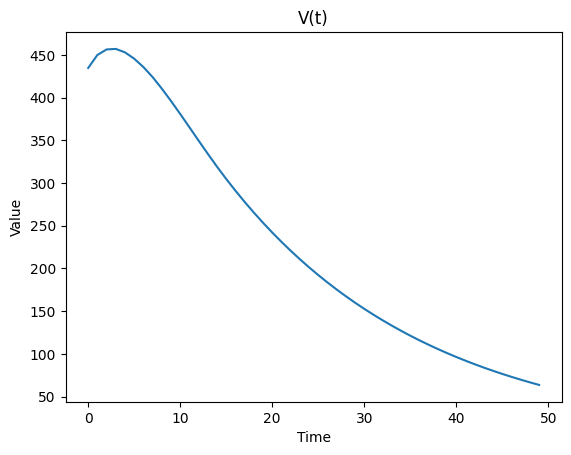

In [18]:
import matplotlib.pyplot as plt

# Plotting the line plot
plt.plot(V)

# Adding labels and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("V(t)")

# Displaying the plot
plt.show

In [19]:
W = []
for t in range(50):
    defection = solve_planner_problem(
        T=200,
        theta=theta,
        gamma=gamma,
        x0=results["X"][t],
        zbar=zbar_2017,
        z0=results["Z"][t],
        pe=pee,
        pa=pa,
    )
    
    W.append(value_decomposition(
        Z=defection["Z"],
        X=defection["X"],
        U=defection["U"],
        V=defection["V"],
        T=200,
        pee=pee,
        pa=pa,
        b=0,
        theta=theta,
    )["total_PV"])

Solving the optimization problem...
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file /var/folders/d1/k6sr3htd7fdgk614mmq8pwq00000gr/T/tmp412ar7fy.pyomo.lp
Reading time = 0.08 seconds
x1: 31400 rows, 62601 columns, 155966 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 31400 rows, 62601 columns and 155966 nonzeros
Model fingerprint: 0x54b2818a
Model has 200 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e-03, 1e+03]
  QObjective range [3e+03, 2e+05]
  Bounds range     [3e-04, 1e+00]
  RHS range        [6e-07, 7e+00]
Presolve removed 15602 rows and 15604 columns
Presolve time: 0.02s
Presolved: 15798 rows, 46997 columns, 93715 nonzeros
Presolved model has 200 quadratic objective terms
Ordering time: 0.01s

Barrier stati

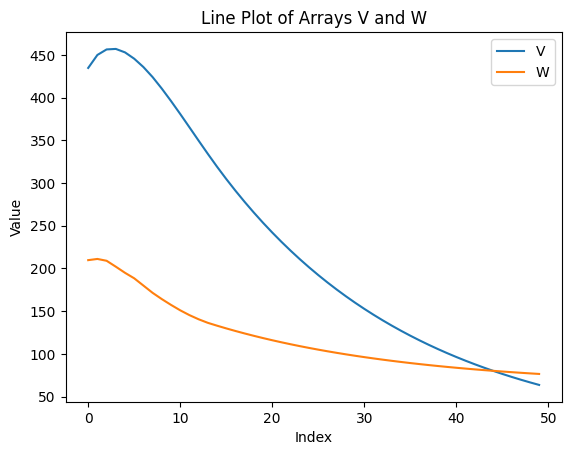

In [20]:
# Plotting the line plots for V and W
plt.plot(V, label='V(t)')
plt.plot(W, label='W(t)')

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('V()')

# Displaying the plot
plt.show()
